In [1]:
# example, some code based on https://github.com/shihenw/convolutional-pose-machines-release

In [2]:
from __future__ import print_function
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import cPickle as pickle

import skimage.io
import skimage.transform
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import cv2

import tensorflow as tf
import cpm

In [3]:
def detect_objects_heatmap(heatmap):
  data = 256 * heatmap 
  data_max = filters.maximum_filter(data, 3)
  maxima = (data == data_max)
  data_min = filters.minimum_filter(data, 3)
  diff = ((data_max - data_min) > 0.3)
  maxima[diff == 0] = 0
  labeled, num_objects = ndimage.label(maxima)
  slices = ndimage.find_objects(labeled)
  objects = np.zeros((num_objects, 2), dtype=np.int32)
  for oid,(dy,dx) in enumerate(slices):
    objects[oid,:] = [(dy.start + dy.stop - 1)/2, (dx.start + dx.stop - 1)/2]
  return objects

def gaussian_kernel(h, w, sigma_h, sigma_w):
  yx = np.mgrid[-h//2:h//2,-w//2:w//2]**2
  return np.exp(-yx[0,:,:] / sigma_h**2 - yx[1,:,:] / sigma_w**2)

def prepare_input_posenet(image, objects, size_person, size, sigma=25, max_num_objects=16, border=400):
  result = np.zeros((max_num_objects, size[0], size[1], 4))
  padded_image = np.zeros((1,size_person[0]+border,size_person[1]+border,4))
  padded_image[0,border//2:-border//2,border//2:-border//2,:3] = image
  assert len(objects) < max_num_objects
  for oid, (yc, xc) in enumerate(objects):
    dh, dw = size[0]//2, size[1]//2
    y0, x0, y1, x1 = np.array([yc-dh, xc-dw, yc+dh, xc+dw]) + border//2
    result[oid,:,:,:4] = padded_image[:,y0:y1,x0:x1,:]
    result[oid,:,:,3] = gaussian_kernel(size[0], size[1], sigma, sigma)
  return np.split(result, [3], 3)

def detect_parts_heatmaps(heatmaps, centers, size, num_parts=14):
  parts = np.zeros((len(centers), num_parts, 2), dtype=np.int32)
  for oid, (yc, xc) in enumerate(centers):
    part_hmap = skimage.transform.resize(np.clip(heatmaps[oid], -1, 1), size) 
    for pid in xrange(num_parts):
      y, x = np.unravel_index(np.argmax(part_hmap[:,:,pid]), size)
      parts[oid,pid] = y+yc-size[0]//2,x+xc-size[1]//2
  return parts

LIMBS = np.array([1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 13, 14]).reshape((-1,2))-1
COLORS = [[0, 0, 255], [0, 170, 255], [0, 255, 170], [0, 255, 0], [170, 255, 0],
          [255, 170, 0], [255, 0, 0], [255, 0, 170], [170, 0, 255]]

def draw_limbs(image, parts):
  for oid in xrange(parts.shape[0]):
    for lid, (p0, p1) in enumerate(LIMBS):
      y0, x0 = parts[oid][p0]
      y1, x1 = parts[oid][p1]
      cv2.line(image, (x0,y0), (x1,y1), COLORS[lid], 2)

In [4]:
# NOTE: modify the paths appropriately
# person (body center)
person_path = './_trained_person_MPI/'
person_deploy_file = person_path + 'pose_deploy_copy_4sg_resize.prototxt'
person_model_file = person_path + 'pose_iter_70000.caffemodel'
person_pkl_file = person_path + 'params.pkl'
# pose (parts)
pose_path = './_trained_MPI/'
pose_deploy_file = pose_path + 'pose_deploy_resize.prototxt'
pose_model_file = pose_path + 'pose_iter_320000.caffemodel'
pose_pkl_file = pose_path + 'params.pkl'

In [5]:
# NOTE: this you gotta run in a separate session
# caffe_root = '<path-to-caffe-python-installation>'
# import sys
# sys.path.append(caffe_root)
# import caffe

# def convert_weights(W):
#   if len(W.shape) == 4:
#     return W.transpose((2,3,1,0))
#   elif len(W.shape) == 1:
#     return W
#   else:
#     raise ValueError('Unsupported weights')

# def dump_parameters(net, path):
#   params = { name : [ convert_weights(blob.data) for blob in blobs ]
#                      for name, blobs in net.params.iteritems() }
#   pickle.dump(params, open(path, 'w+'))
  
# person_net = caffe.Net(person_deploy_file, caffe.TEST, weights=person_model_file)
# pose_net = caffe.Net(pose_deploy_file, caffe.TEST, weights=pose_model_file)  
  
# dump_parameters(person_net, person_pkl_file)
# dump_parameters(pose_net, pose_pkl_file)  

In [6]:
# loading weights from pickles
person_params = pickle.load(open(person_pkl_file))
pose_params = pickle.load(open(pose_pkl_file))

In [7]:
def tf_init_weights(root_scope, params_dict):
  names_to_values = {}
  for scope, weights in params_dict.iteritems():
    variables = tf.get_collection(tf.GraphKeys.VARIABLES, 
                                  '%s/%s' % (root_scope, scope))
    assert len(weights) == len(variables)
    for v, w in zip(variables, weights):
      names_to_values[v.name] = w
  return tf.contrib.framework.assign_from_values(names_to_values)    

import sys
sys.path.append('cpm')
import cpm

tf.reset_default_graph()

with tf.variable_scope('CPM'):
  # input dims for the person network
  PH, PW = 376, 656
  image_in = tf.placeholder(tf.float32, [1,PH,PW,3])
  heatmap_person = cpm.inference_person(image_in)
  heatmap_person_large = tf.image.resize_images(heatmap_person, PH, PW)
  init_person_op, init_person_feed = tf_init_weights('CPM/PersonNet', person_params)
  
  # input dims for the pose network
  N, H, W = 16, 376, 376
  pose_image_in = tf.placeholder(tf.float32, [N,H,W,3])
  pose_centermap_in = tf.placeholder(tf.float32, [N,H,W,1])
  heatmap_pose = cpm.inference_pose(pose_image_in, pose_centermap_in)
  init_pose_op, init_pose_feed = tf_init_weights('CPM/PoseNet', pose_params)

In [8]:
fname = 'nadal.png'

image = skimage.io.imread(fname)
image = skimage.transform.resize(image, [PH, PW], preserve_range=True).astype(np.uint8)

with tf.Session() as sess:
  sess.run(init_person_op, init_person_feed)
  b_image = image[np.newaxis] / 255.0 - 0.5
  hmap_person = sess.run(heatmap_person_large, { image_in : b_image })
  
# TODO: make this in tf as well?  
hmap_person = np.squeeze(hmap_person)  
centers = detect_objects_heatmap(hmap_person)  
b_pose_image, b_pose_cmap = prepare_input_posenet(b_image[0], centers, [PH, PW], [H, W])  

with tf.Session() as sess:
  sess.run(init_pose_op, init_pose_feed)
  
  feed_dict = {
    pose_image_in : b_pose_image,
    pose_centermap_in : b_pose_cmap
  }
  
  _hmap_pose = sess.run(heatmap_pose, feed_dict)

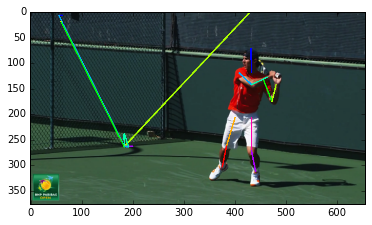

In [9]:
parts = detect_parts_heatmaps(_hmap_pose, centers, [H, W])
draw_limbs(image, parts)
plt.imshow(image)